https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
https://github.com/MattShannon/mcd/tree/master/test_data/aligned-synth-examples
https://zhuanlan.zhihu.com/p/89763124

In [1]:
import os
import math
import glob
import librosa
import pyworld
import pysptk
import numpy as np
import matplotlib.pyplot as plot

In [4]:
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True) # return音频信号和采样率

    return wav

# 求 MCD 的值
def log_spec_dB_dist(x, y):
    log_spec_dB_const = 10.0 / math.log(10.0) * math.sqrt(2.0)
    diff = x - y

    return log_spec_dB_const * math.sqrt(np.inner(diff, diff))


SAMPLING_RATE = 22050
FRAME_PERIOD = 5.0

In [3]:
# Paths to target reference and converted synthesised wavs
stgan_vc_wav_paths = glob.glob('./data/official_stargan-vc/wavs/*')
stgan_vc2_wav_paths = glob.glob('./data/official_stargan-vc2/wavs/*')

stgan_vc2_wav_paths[:8]

['./data/official_stargan-vc2/wavs\\conv',
 './data/official_stargan-vc2/wavs\\trg']

<class 'numpy.ndarray'>


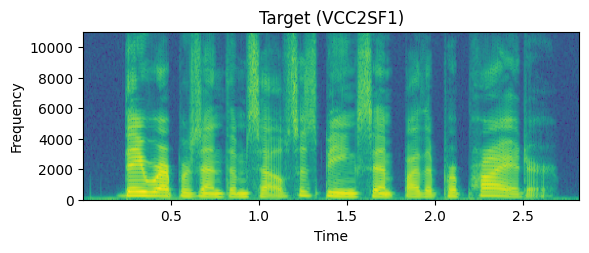

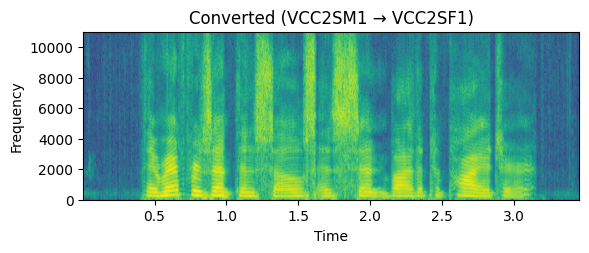

In [4]:
# Load the wavs
# conv:converted  trg:target
vc2_trg_ref = load_wav('./data/official_stargan-vc2/wavs/trg/VCC2SF1_30016.wav', sr=SAMPLING_RATE)
vc2_conv_synth = load_wav('./data/official_stargan-vc2/wavs/conv/VCC2SF1_VCC2SM1_STARGANVC2_30016.wav', sr=SAMPLING_RATE)

print(type(vc2_trg_ref))

plot.subplot(212)
plot.specgram(vc2_trg_ref, Fs=SAMPLING_RATE)
plot.title('Target (VCC2SF1)')
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.show()

plot.subplot(212)
plot.specgram(vc2_conv_synth, Fs=SAMPLING_RATE)
plot.title('Converted (VCC2SM1 → VCC2SF1)')
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.show()

# 2 Extract Acoustic Features

In [5]:
def wav2mcep_numpy(wavfile, target_directory, alpha=0.65, fft_size=512, mcep_size=34):
    # make relevant directories
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    loaded_wav = load_wav(wavfile, sr=SAMPLING_RATE)

    # Use WORLD vocoder to spectral envelope
    _, sp, _ = pyworld.wav2world(loaded_wav.astype(np.double), fs=SAMPLING_RATE,
                                   frame_period=FRAME_PERIOD, fft_size=fft_size) # frame_period表示连续帧之间的周期

    # Extract MCEP features 处理频率包络
    mgc = pysptk.sptk.mcep(sp, order=mcep_size, alpha=alpha, maxiter=0,
                           etype=1, eps=1.0E-8, min_det=0.0, itype=3)

    fname = os.path.basename(wavfile).split('.')[0]
    np.save(os.path.join(target_directory, fname + '.npy'),
            mgc,
            allow_pickle=False)


In [6]:
alpha = 0.65  # commonly used at 22050 Hz
fft_size = 512
mcep_size = 34

vc_trg_wavs = glob.glob('./data/official_stargan-vc/wavs/trg/*')
vc_trg_mcep_dir = './data/official_stargan-vc/mceps_numpy/trg'
vc_conv_wavs = glob.glob('./data/official_stargan-vc/wavs/conv/*')
vc_conv_mcep_dir = './data/official_stargan-vc/mceps_numpy/conv'

vc2_trg_wavs = glob.glob('./data/official_stargan-vc2/wavs/trg/*')
vc2_trg_mcep_dir = './data/official_stargan-vc2/mceps_numpy/trg'
vc2_conv_wavs = glob.glob('./data/official_stargan-vc2/wavs/conv/*')
vc2_conv_mcep_dir = './data/official_stargan-vc2/mceps_numpy/conv'

for wav in vc_trg_wavs:
    wav2mcep_numpy(wav, vc_trg_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)

for wav in vc_conv_wavs:
    wav2mcep_numpy(wav, vc_conv_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)

for wav in vc2_trg_wavs:
    wav2mcep_numpy(wav, vc2_trg_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)

for wav in vc2_conv_wavs:
    wav2mcep_numpy(wav, vc2_conv_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)


# 3 Calculate MCD

In [7]:
def average_mcd(ref_mcep_files, synth_mcep_files, cost_function):
    """
    Calculate the average MCD.
    :param ref_mcep_files: list of strings, paths to MCEP target reference files
    :param synth_mcep_files: list of strings, paths to MCEP converted synthesised files
    :param cost_function: distance metric used
    :returns: average MCD, total frames processed
    """
    min_cost_tot = 0.0
    frames_tot = 0

    for ref in ref_mcep_files:
        for synth in synth_mcep_files:
            # get the trg_ref and conv_synth speaker name and sample id
            # 文件命名中取 '_' 分隔的第一个和最后一个字符串作为匹配同一对目标-转换语音的唯一标识
            ref_fsplit, synth_fsplit = os.path.basename(ref).split('_'), os.path.basename(synth).split('_')
            ref_spk, ref_id = ref_fsplit[0], ref_fsplit[-1]
            synth_spk, synth_id = synth_fsplit[0], synth_fsplit[-1]

            # if the speaker name is the same and sample id is the same, do MCD
            if ref_spk == synth_spk and ref_id == synth_id:
                # load MCEP vectors
                ref_vec = np.load(ref)
                ref_frame_no = len(ref_vec)
                synth_vec = np.load(synth)

                # dynamic time warping using librosa
                min_cost, _ = librosa.sequence.dtw(ref_vec[:, 1:].T, synth_vec[:, 1:].T,
                                                   metric=cost_function)

                min_cost_tot += np.mean(min_cost)
                frames_tot += ref_frame_no

    mean_mcd = min_cost_tot / frames_tot

    return mean_mcd, frames_tot

In [9]:
vc_trg_refs = glob.glob('./data/official_stargan-vc/mceps_numpy/trg/*')
vc_conv_synths = glob.glob('./data/official_stargan-vc/mceps_numpy/conv/*')
vc2_trg_refs = glob.glob('./data/official_stargan-vc2/mceps_numpy/trg/*')
vc2_conv_synths = glob.glob('./data/official_stargan-vc2/mceps_numpy/conv/*')

cost_function = log_spec_dB_dist

vc_mcd, vc_tot_frames_used = average_mcd(vc_trg_refs, vc_conv_synths, cost_function)
vc2_mcd, vc2_tot_frames_used = average_mcd(vc2_trg_refs, vc2_conv_synths, cost_function)

# frames_used 好像表示取了多少帧
print(f'StarGAN-VC MCD = {vc_mcd} dB, calculated over a total of {vc_tot_frames_used} frames')
print(f'StarGAN-VC2 MCD = {vc2_mcd} dB, calculated over a total of {vc2_tot_frames_used} frames')

StarGAN-VC MCD = 7.1743860350142645 dB, calculated over a total of 7262 frames
StarGAN-VC2 MCD = 6.391493428397028 dB, calculated over a total of 7262 frames
StarGAN-VC MCD = 7.1743860350142645 dB, calculated over a total of 7262 frames
StarGAN-VC2 MCD = 6.391493428397028 dB, calculated over a total of 7262 frames


In [1]:
from pymcd.mcd import Calculate_MCD

vc_trg_refs = glob.glob('./data/official_stargan-vc/wavs/trg/*')
vc_conv_synths = glob.glob('./data/official_stargan-vc/wavs/conv/*')
vc2_trg_refs = glob.glob('./data/official_stargan-vc2/wavs/trg/*')
vc2_conv_synths = glob.glob('./data/official_stargan-vc2/wavs/conv/*')

def average_mcd(ref_mcep_files, synth_mcep_files):
    min_cost_tot = 0.0
    frames_tot = 0
    counts = len(ref_mcep_files)
    print(counts)
    sum = 0.0

    for ref in ref_mcep_files:
        for synth in synth_mcep_files:
            # print(os.path.basename(synth))

            # get the trg_ref and conv_synth speaker name and sample id
            # 文件命名中取 '_' 分隔的第一个和最后一个字符串作为匹配同一对目标-转换语音的唯一标识
            ref_fsplit, synth_fsplit = os.path.basename(ref).split('_'), os.path.basename(synth).split('_')
            ref_spk, ref_id = ref_fsplit[0], ref_fsplit[-1]
            synth_spk, synth_id = synth_fsplit[0], synth_fsplit[-1]

            # if the speaker name is the same and sample id is the same, do MCD
            if ref_spk == synth_spk and ref_id == synth_id:
                mcd_value = mcd_toolbox.calculate_mcd(ref, synth)
                print(mcd_value)
                sum += mcd_value

    return sum / counts

mcd_toolbox = Calculate_MCD(MCD_mode='dtw')
print(average_mcd(vc_trg_refs, vc_conv_synths))
print(average_mcd(vc2_trg_refs, vc2_conv_synths))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7.920876700549595


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8.699282590839204


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6.881484262744833


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4.59590381711853


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6.286975992771968


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.808745756726942


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7.289165113919412


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.571846116928746


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6.616370142125885


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8.010944942931797


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6.105272795994883


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7.227849874025359
6.751226508889762
12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7.221414974539129


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7.360110242963003


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.940978494922856


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3.593603359761289


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3.814391403718658


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4.66283122433203


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6.71088418865733


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4.650198945995763


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7.261690879046056


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.181625934807151


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3.3575242341137628


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.172218685983883
5.410622714070076


https://blog.csdn.net/weixin_44649780/article/details/135399901